<a href="https://colab.research.google.com/github/fanny/information-retrieval/blob/master/lab2/text_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Processamento dos texto das notícias

Começamos importando os dados e as dependências. Os dados se encontram no repositório do github, sendo assim fazemos uso de sua url de acesso.  
De dependências, temos:
- [pandas](https://pandas.pydata.org/) e o [numpy](http://www.numpy.org/), para obtenção das estatísticas.
- [ntlk](https://www.nltk.org/) para tokenização e geração de bigramas.   
- [seaborn](https://seaborn.pydata.org/) e matplotlib para geração dos gráficos
- [re](https://docs.python.org/3/library/re.html) para filtrar as palavras válidas

In [213]:
import re

import pandas as pd
import numpy as np

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt_pyp
%matplotlib inline

data = pd.read_csv('https://raw.githubusercontent.com/fanny/information-retrieval/master/lab2/data/results.csv')
data.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,_id,author,date,section,sub_title,text,title,url
0,18,Gazeta do Povo,NaN,educacao,NaN,S o b r e a i n d i c a ç ã o d e q u ...,Populares,https://www.gazetadopovo.com.br/educacao/olavo...
1,6,Agência Estado,NaN,republica,NaN,O l í d e r d o M D B n a C â m a r ...,Populares,https://www.gazetadopovo.com.br/republica/pec-...
2,5,Gazeta do Povo,NaN,curitiba,NaN,D e p o i s d e u m a s e m a n a d e ...,Populares,https://www.gazetadopovo.com.br/curitiba/previ...
3,8,"Raphael Sibila, especial para a Gazeta do Povo",NaN,republica,NaN,“ S e v o c ê n ã o t e m a c a p a ...,Populares,https://www.gazetadopovo.com.br/republica/braz...
4,11,The Daily Signal,NaN,ideias,NaN,P e s s o a s q u e b u s c a m u m a ...,Populares,https://www.gazetadopovo.com.br/ideias/nao-se-...


## Me diga aonde você vai que eu vou varrendo

Agora que temos os dados, precisamos remover as informações que não nos interessam, processo conhecido como *stopping* .
Definimos como não relevantes, as seguintes expressões:
- palavras de tamanho menor que 3
- símbolos
- números  

Para chegar a esse resultado, comecei definindo um regex, que toda vez que encontrasse alguma expressão anterior em cada texto, substituisse por espaço, usando o pacote `re` para manipular o regex  e a função `apply` do pandas, para aplicar essa regra a cada linha do dataframe. Além disso, os valores `na` foram removidos.


In [0]:
def filter_valid_words(text):
  return re.sub(r'(\W+|\d+|\b\w{0,3}\b)', ' ', text.lower())

In [215]:
clean_text = data['text'].dropna()
clean_text = clean_text.apply(filter_valid_words)
clean_text.head(20)

0                                                   ...
1                                                   ...
2                                                   ...
3                                                   ...
4                                                   ...
7                                                   ...
10                                                  ...
11                                                  ...
12                                                  ...
13                                                  ...
14                                                  ...
15     pessoas   buscam   identidade transsexual   n...
16     depois     semana   calor curitiba terá      ...
17      promessas   muitas combater   envelhecimento...
18      líder       câmara baleia rossi   protocolou...
19      meia atacante maicosuel está     situação in...
20     concretizar   compra     carro novo   sempre ...
21          horário   verão mudanças   secom    

## J. R. R. Tolkien

Dado que ignoramos as palavras que não são de nosso interesse, podemos *tokenizar* as palavras. E para nos auxiliar,  fazemos uso do método `word_tokenize` da biblioteca `nltk`.

In [216]:
all_formatted_text = clean_text.str.cat(sep=' ') 

word_list = word_tokenize(all_formatted_text)
words = pd.DataFrame(word_list, columns=['word'])
unique_words = words['word'].unique()
words.head(15)

,word
0,pessoas
1,buscam
2,identidade
3,transsexual
4,nasceram
5,assim
6,crianças
7,devem
8,estimuladas
9,fazer


## Sintonize na frequência

> "Entender a natureza estatística do texto é fundamental para entender modelos de recuperação da informação e algoritmos de rankeamento"

*trecho exraido do livro*

Tendo conhecimento dessa importância, extraímos para cada token gerado, a quantidade de ocorrências(tanto a absoluta, quanto relativa) do mesmo e sumarizamos na tabela abaixo, para tal, usamos o método `value_counts` do `pandas`,  e o `boolean indexing` para filtrar os dados apenas com as características de interesse, nesse caso, palavras que ocorrem mais de mil vezes ou apenas uma vez.

In [0]:
def get_percentage(value):
  return value * 100

In [218]:
frequencies = words['word'].value_counts()
relative_frequencies = words['word'].value_counts(normalize=True)
relative_frequencies = relative_frequencies.apply(get_percentage)

relative_frequencies.head(10)

para       2.196995
mais       0.855642
como       0.737038
pela       0.460296
pelo       0.446176
também     0.446176
disse      0.423585
governo    0.412290
sobre      0.398170
anos       0.381227
Name: word, dtype: float64

In [219]:
statistics = {}
statistics['total_documents'] = len(clean_text)
statistics['total_words_occurences'] = len(words)
statistics['vocabulary_size'] = len(unique_words)
statistics['words_occurring_greater_1000_times'] = len(frequencies[frequencies > 1000])
statistics['words_occurring_once'] = len(frequencies[frequencies == 1])

data_statistics = pd.DataFrame(statistics, index=[0])
data_statistics

,total_documents,total_words_occurences,vocabulary_size,words_occurring_greater_1000_times,words_occurring_once
0,119,35412,9380,0,5023


## TOP 50 HITS


Como já tinhamos os dados estatísticos, para conseguir exibir o ranking, apenas criamos um novo dataframe com os critérios de rankeamento, que são:

- frequência
- posição(ranking)
- porcentagem de ocorrências totais
- *c* = r.Pr

Feito isso, exibimos apenas as 50 primeiros dados

In [193]:
ranking = np.arange(1,len(unique_words)+1)

most_frequent_words = {
    'frequency': frequencies,
    'r': ranking,
    'Pr(%)': relative_frequencies,
    'r.Pr': relative_frequencies * ranking
}

most_frequent_words = pd.DataFrame(most_frequent_50_words)
most_frequent_words.head(50)

,frequency,r,Pr(%),r.Pr
para,778,1,2.196995,2.196995
mais,303,2,0.855642,1.711284
como,261,3,0.737038,2.211115
pela,163,4,0.460296,1.841184
pelo,158,5,0.446176,2.230882
também,158,6,0.446176,2.677059
disse,150,7,0.423585,2.965097
governo,146,8,0.412290,3.298317
sobre,141,9,0.398170,3.583531
anos,135,10,0.381227,3.812267


## "I see it, I like it"


Para conseguir visualizar como a frequência influência no ranking, como descreve a *Lei de Zipf*, tanto para os unigramas quanto para os bigramas, no caso do segundo, foi necessário utilizar o método `bigrams` do `nltk`, que gera os pares de palavras, usamos gráficos e como pode ser visto abaixo, quanto maior o ranking menor a frequência. No gráfico dos bigramas isso não ocorre, porque todos os pares têm frequencia igual a 1.

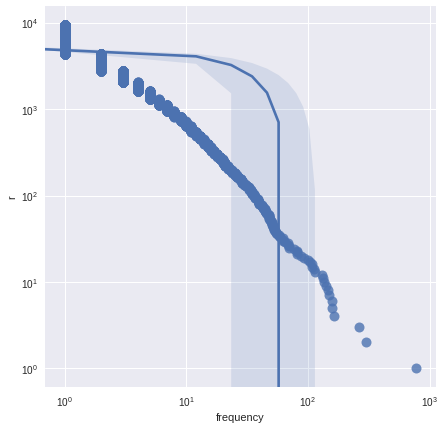

In [194]:
f, ax = plt_pyp.subplots(figsize=(7, 7))
ax.set(xscale="log", yscale="log")

sns.regplot(x="frequency", y="r", data=most_frequent_50_words,ax=ax, scatter_kws={"s": 100})

In [195]:

bigrams = list(nltk.bigrams(unique_words))
bigrams_frequency = nltk.FreqDist(bigrams)

bigrams = pd.DataFrame({
    'bigram': list(bigrams_frequency.keys()),
    'frequency': list(bigrams_frequency.values()),
    'ranking': np.arange(1,len(bigrams)+1)
})
bigrams.head()

,bigram,frequency,ranking
0,"(pessoas, buscam)",1,1
1,"(buscam, identidade)",1,2
2,"(identidade, transsexual)",1,3
3,"(transsexual, nasceram)",1,4
4,"(nasceram, assim)",1,5


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3099: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1.0, right=1.0
  self.set_xlim(upper, lower, auto=None)


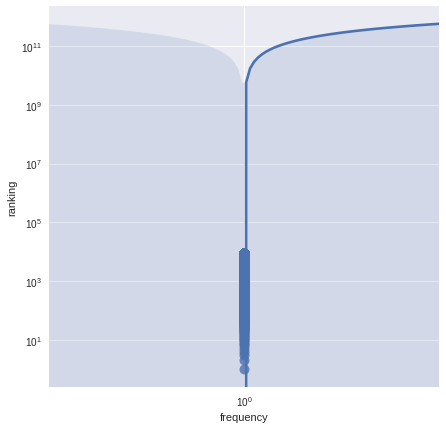

In [196]:
f, ax = plt_pyp.subplots(figsize=(7, 7))
ax.set(xscale="log", yscale="log")

sns.regplot(x="frequency", y="ranking", data=bigrams,ax=ax, scatter_kws={"s": 100})

## Previsões

Uma palavra pode ocorrer n vezes em um texto, se tivermos interessados em calcular a proporção de palavras com essa frequência, a *Lei de Zipf* afirma que ela será dada por essa fórmula:   
`1/n*(n+1)`  

Para obter os valores de frequencias, agrupamos(`groupby`) e aplicamos essa fórmula para cada um deles, desse modo, obtemos a proporção estimada.
Para a proporção real, usamos a quantidade de elementos de cada frequência e dividimos pelo total(tam do vocabulário).


In [0]:
def get_current_proportion(frequency):
  return frequency / statistics['vocabulary_size']

def get_predicted_proportions(occurrences):
  predicted_proportions = [] 
  for n in occurrences:
    predicted_proportion = 1 / (n * (n + 1))
    predicted_proportions.append(predicted_proportion)
  
  return predicted_proportions

In [0]:
grouped_words_by_frequency = most_frequent_50_words.groupby('frequency')['r']
current_number_of_words = grouped_words_by_frequency.count()
number_of_occurrences = grouped_words_by_frequency.groups.keys()
current_proportion = current_number_of_words.apply(get_current_proportion)
predicted_proportions = get_predicted_proportions(number_of_occurrences)

In [222]:
proportions_of_words = {
    'predicted_proportions': predicted_proportions,
    'current_proportion': current_proportion,
    'current_number_of_words': current_number_of_words
}
proportions_of_words = pd.DataFrame(proportions_of_words)
proportions_of_words.index.names = ['number_of_occurrences']
proportions_of_words.head(10)

,predicted_proportions,current_proportion,current_number_of_words
number_of_occurrences,,,
1,0.500000,0.535501,5023
2,0.166667,0.169616,1591
3,0.083333,0.078252,734
4,0.050000,0.045522,427
5,0.033333,0.033369,313
6,0.023810,0.019083,179
7,0.017857,0.018443,173
8,0.013889,0.013006,122
9,0.011111,0.010554,99
